### Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

### Load Dataset

In [3]:
df = pd.read_csv('data/processed_train.csv') #train and test data
val = pd.read_csv('data/processed_test.csv') #validation data

### Train Test Split

In [4]:
X = df.drop(columns=["y"])
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 13), (200, 13), (800,), (200,))

In [5]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,poutcome
920,43,blue-collar,married,secondary,no,184,no,yes,cellular,jul,1019,11,unknown
550,35,admin.,married,secondary,no,-87,yes,no,cellular,jun,1363,7,unknown
303,55,blue-collar,married,primary,no,1649,yes,no,cellular,may,52,3,unknown
184,35,technician,single,tertiary,no,670,no,no,cellular,oct,301,2,unknown
501,39,technician,married,tertiary,no,1524,no,no,cellular,apr,567,1,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,40,management,married,tertiary,no,0,yes,no,cellular,mar,506,2,unknown
818,33,student,married,secondary,no,1536,no,no,cellular,aug,258,2,success
926,63,retired,married,secondary,no,538,no,no,cellular,aug,373,2,unknown
578,29,technician,married,tertiary,no,1413,yes,no,cellular,jul,170,4,unknown


### Data Preprocessing

In [6]:
nums = ['age', 'balance', 'duration']
cats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'campaign', 'poutcome']

In [7]:
preprocessor = ColumnTransformer([
    ('numeric',  Pipeline([('scaler', MinMaxScaler())]), nums),
    ('categoric', Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]), cats)
])

### KNN Model

##### Train tanpa Hyperparameter Tuning

In [8]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

knn_model = pipeline.fit(X_train, y_train)

print('Akurasi Train: ', knn_model.score(X_train, y_train), '\nAkurasi Test: ',knn_model.score(X_test, y_test))

Akurasi Train:  0.78 
Akurasi Test:  0.755


##### Train dengan Hyperparameter Tuning

In [9]:
knn_params = {'algo__n_neighbors': np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
              'algo__weights': ['uniform', 'distance'],
              'algo__p': [1, 1.5, 2]}

In [10]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

knn_model = GridSearchCV(pipeline, knn_params, cv=3, n_jobs=-1, verbose=1)
knn_model.fit(X_train, y_train)

print(knn_model.best_params_)
print(knn_model.score(X_train, y_train), knn_model.best_score_, knn_model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s


{'algo__n_neighbors': 9, 'algo__p': 1, 'algo__weights': 'uniform'}
0.7725 0.705011592652042 0.765


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    2.6s finished


In [26]:
knn_cv = pd.concat([pd.DataFrame(knn_model.cv_results_["params"]),
                   pd.DataFrame(knn_model.cv_results_["split0_test_score"], columns=["Accuracy CV1"]),
                   pd.DataFrame(knn_model.cv_results_["split1_test_score"], columns=["Accuracy CV2"]),
                   pd.DataFrame(knn_model.cv_results_["split2_test_score"], columns=["Accuracy CV3"]),
                   pd.DataFrame(knn_model.cv_results_["mean_test_score"], columns=["Mean Accuracy"])],
                   axis=1)
knn_cv.sort_values(by='Mean Accuracy', ascending=False).head()

,algo__n_neighbors,algo__p,algo__weights,Accuracy CV1,Accuracy CV2,Accuracy CV3,Mean Accuracy
28,9,2.0,uniform,0.692884,0.707865,0.714286,0.705012
24,9,1.0,uniform,0.692884,0.707865,0.714286,0.705012
22,7,2.0,uniform,0.704120,0.681648,0.725564,0.703777
18,7,1.0,uniform,0.700375,0.700375,0.699248,0.699999
34,11,2.0,uniform,0.707865,0.707865,0.684211,0.699980


Dilakukan hyperparameter tuning berupa Gridsearch CV dengan 3 Fold. Adapun parameter yang di optimasi adalah:
- n neighbors : Rentang 1 - 29, 9 adalah n terbaik
- weights : uniform atau distance, uniform adalah weight terbaik
- p : 1, 1.5, 2, dengan 1 adalah p terbaik

### SVM Model

##### Train tanpa Hyperparameter Tuning

In [12]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC())
])

svc_model = pipeline.fit(X_train, y_train)

print('Akurasi Train: ', svc_model.score(X_train, y_train), '\nAkurasi Test: ', svc_model.score(X_test, y_test))

Akurasi Train:  0.79875 
Akurasi Test:  0.78


##### Train dengan Hyperparameter Tuning

In [13]:
svm_params = {'algo__gamma': np.array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
              'algo__C': np.array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [14]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500, probability=True))
])

svm_model = GridSearchCV(pipeline, svm_params, cv=3, n_jobs=-1, verbose=1)
svm_model.fit(X_train, y_train)

print(svm_model.best_params_)
print(svm_model.score(X_train, y_train), svm_model.best_score_, svm_model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 132 out of 147 | elapsed:    2.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    3.1s finished


{'algo__C': 1000.0, 'algo__gamma': 0.001}
0.81375 0.7837571456731718 0.825


In [27]:
svm_cv = pd.concat([pd.DataFrame(svm_model.cv_results_["params"]),
                   pd.DataFrame(svm_model.cv_results_["split0_test_score"], columns=["Accuracy CV1"]),
                   pd.DataFrame(svm_model.cv_results_["split1_test_score"], columns=["Accuracy CV2"]),
                   pd.DataFrame(svm_model.cv_results_["split2_test_score"], columns=["Accuracy CV3"]),
                   pd.DataFrame(svm_model.cv_results_["mean_test_score"], columns=["Mean Accuracy"])],
                   axis=1)
svm_cv.sort_values(by='Mean Accuracy', ascending=False).head()

,algo__C,algo__gamma,Accuracy CV1,Accuracy CV2,Accuracy CV3,Mean Accuracy
42,1000.0,0.001,0.786517,0.775281,0.789474,0.783757
36,100.0,0.010,0.805243,0.771536,0.759398,0.778726
30,10.0,0.100,0.741573,0.760300,0.740602,0.747491
43,1000.0,0.010,0.707865,0.756554,0.774436,0.746285
37,100.0,0.100,0.715356,0.719101,0.778195,0.737551


Dilakukan hyperparameter tuning berupa Gridsearch CV dengan 3 Fold. Adapun parameter yang di optimasi adalah:
- gamma : Rentang log -3 sampai 3, 0.001 adalah gamma terbaik
- C : Rentang log -3 sampai 3, 1000 adalah C terbaik

### Feature Importance

In [16]:
imp = permutation_importance(svc_model, X_train, y_train, n_repeats=5, n_jobs=1, random_state=42)

In [17]:
df_imp = pd.DataFrame({"feature": X_train.columns,
                       "importance": imp["importances_mean"],
                       "stdev": imp["importances_std"]
                      }).sort_values("importance", ascending=False)
df_imp

,feature,importance,stdev
6,housing,0.08300,0.011769
10,duration,0.07200,0.006052
12,poutcome,0.06675,0.013933
11,campaign,0.04675,0.004373
1,job,0.04225,0.006344
3,education,0.03025,0.011948
2,marital,0.01125,0.003791
7,loan,0.01100,0.001658
0,age,0.00250,0.000791
4,default,0.00125,0.000000


In [18]:
# Normalize

df_imp[["importance", "stdev"]] = df_imp[["importance", "stdev"]] / df_imp.importance.sum()
df_imp

,feature,importance,stdev
6,housing,0.225850,0.032023
10,duration,0.195918,0.016468
12,poutcome,0.181633,0.037913
11,campaign,0.127211,0.011900
1,job,0.114966,0.017263
3,education,0.082313,0.032511
2,marital,0.030612,0.010317
7,loan,0.029932,0.004512
0,age,0.006803,0.002151
4,default,0.003401,0.000000


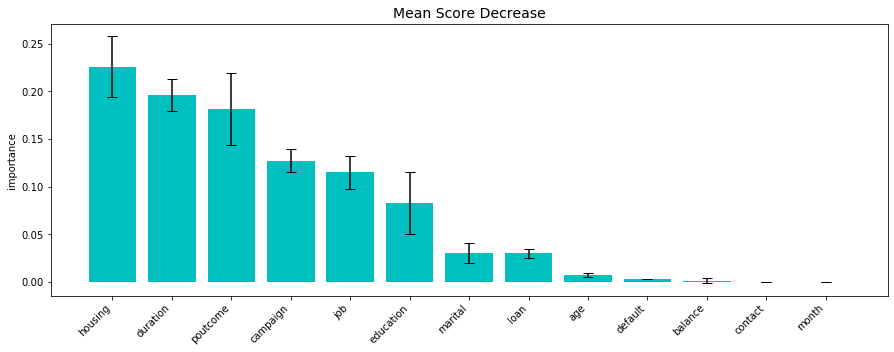

In [19]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(df_imp)), df_imp.importance, yerr=df_imp.stdev, color='c', error_kw={"capsize": 5})
plt.xticks(range(len(df_imp)), df_imp.feature, rotation=45, horizontalalignment='right')
plt.ylabel('importance')
plt.title("Mean Score Decrease", fontsize=14);


Terlihat dari plot feature importance, bahwa feature housing dan duration memegang peranan penting dalam pembuatan model SVM. Sedangkan feature contact dan month terlihat tidak terlalu penting dalam feature importance ini.

### Save Model

In [20]:
pickle.dump(knn_model, open('model/knn_model.pkl', 'wb'))
pickle.dump(svm_model, open('model/svm_model.pkl', 'wb'))

### Evaluation

Evaluasi dilakukan pada dataset Test yang belum pernah dilihat oleh model sebelumnya.

In [21]:
X_val = val.drop(columns=['y']) # data test
y_true = val.y

In [22]:
print('KNN Result')
print(classification_report(y_true, knn_model.predict(X_val)))
print('SVM Result')
print(classification_report(y_true, svm_model.predict(X_val)))

KNN Result
              precision    recall  f1-score   support

          no       0.94      0.75      0.83      4000
         yes       0.24      0.62      0.35       521

    accuracy                           0.73      4521
   macro avg       0.59      0.68      0.59      4521
weighted avg       0.86      0.73      0.77      4521

SVM Result
              precision    recall  f1-score   support

          no       0.96      0.77      0.86      4000
         yes       0.31      0.77      0.44       521

    accuracy                           0.77      4521
   macro avg       0.63      0.77      0.65      4521
weighted avg       0.89      0.77      0.81      4521



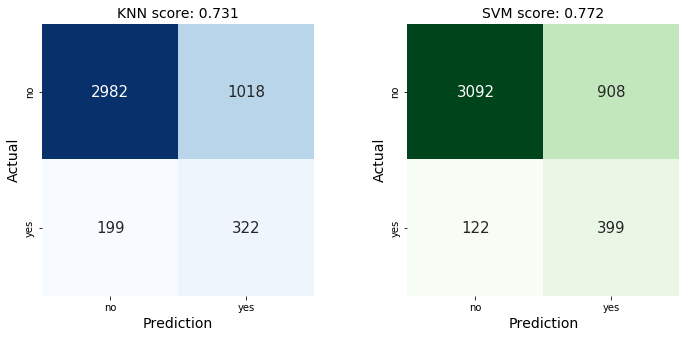

In [23]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(121)
labels = np.unique(y_true)
cm = confusion_matrix(y_true, knn_model.predict(X_val), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'KNN score: {knn_model.score(X_val, y_true):.3f}', fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=90, verticalalignment='center')

plt.subplot(122)
labels = np.unique(y_true)
cm = confusion_matrix(y_true, svm_model.predict(X_val), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'SVM score: {svm_model.score(X_val, y_true):.3f}', fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=90, verticalalignment='center')
plt.show()

In [24]:
y_val = y_true.map({'no':0, 'yes':1})

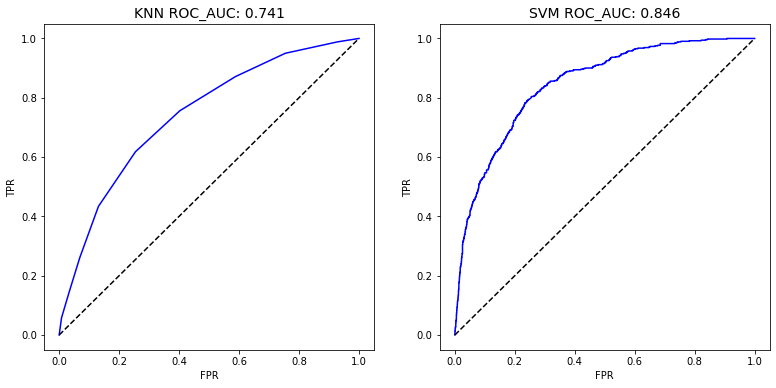

In [25]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
prob = knn_model.predict_proba(X_val)[:, 1]
fpr, tpr, t_roc = roc_curve(y_val, prob)
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"KNN ROC_AUC: {auc(fpr, tpr):.3f}", fontsize=14)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.subplot(122)
prob = svm_model.predict_proba(X_val)[:, 1]
fpr, tpr, t_roc = roc_curve(y_val, prob)
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"SVM ROC_AUC: {auc(fpr, tpr):.3f}", fontsize=14)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("FPR")
plt.ylabel("TPR");

Dari hasil evaluasi ini didapatkan model SVM menghasilkan akurasi yang cukup tinggi dalam memprediksi output apakah klien tersebut akan melakukan pembelian atau tidak pada kampanye marketing yang dijalankan bank. Dengan adanya model ini tentunya sangat membantu dalam melakukan process marketing. Jadi manager marketing dapat memfokuskan marketing terhadap klien yang mempunyai probabilitas tinggi untuk membeli produk tersebut, sehingga dapat menghemat waktu, tenaga, serta biaya yang dikeluarkan untuk promosi produk.